# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

Training imagenet fast and cheaply: https://www.fast.ai/2018/04/30/dawnbench-fastai/

First lets load required modules:

In [1]:
import numpy as np
import random as rn
from dotenv import load_dotenv
import os
from skimage import io
from skimage.transform import resize, rotate
from skimage.util import pad
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

import itertools

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate, Reshape, Flatten
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.metrics import confusion_matrix
# import tensorflow as tf

import datetime
import time
import threading
load_dotenv()

Using TensorFlow backend.


True

 Then seed the random number generators to make results reproducible:

In [2]:
rn.seed(42)
np.random.seed(42)

Lets load some example data to get started and add some data augmentation increase the size of the training data.

In [3]:
datafolder = os.getenv("DATAFOLDER")
outputfolder = os.getenv("OUTPUTFOLDER")
imgfolder = os.path.join(datafolder, 'MiniZoo','imgs')

In [4]:
# Code from:
# https://github.com/keras-team/keras/issues/1638

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        with self.lock:
            return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

Need some way of propagating the size of the image that is invariant to rotations. I am unhappy about the rigidity of the default ImageDataGenerator. I make my own custom data generator.

In [5]:
# See: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
# For additional possible transformations.

def make_square(image, mode='symmetric'):
    if max(image.shape) > 224:
        max_dim = max(image.shape)
        pads = ((int((max_dim-image.shape[0])/2),
                int((max_dim-image.shape[0])/2)),
                (int((max_dim-image.shape[1])/2),
                int((max_dim-image.shape[1])/2)))
        if (mode=='constant'):
            image = pad(image,pads , mode=mode, constant_values=255)
        else:
            image = pad(image,pads , mode=mode)
        return resize(image, (224,224), mode=mode)
    else:
        max_dim = 224
        pads = ((0, int((max_dim-image.shape[0]))),
                (0, int((max_dim-image.shape[1])/2)))
        if (mode=='constant'):
            image = pad(image,pads , mode=mode, constant_values=255)
        else:
            image = pad(image,pads , mode=mode)
        return resize(image, (224,224), mode=mode)

def augment_image(image):
    if(np.random.choice([True, False])):
        image = np.flip(image, axis=1)
    max_dim = max(image.shape)
    #pads = ((0, int((max_dim-image.shape[0]))),
    #            (0, int((max_dim-image.shape[1])/2)))
    #image = pad(image,pads , mode='constant', constant_values=255)
    #angle = np.random.random_integers(0,359)
    #resize_var = np.random.choice([True, False])
    #image = rotate(image, angle, resize=True, mode=np.random.choice(['symmetric', 'reflect', 'wrap', 'edge']))
    return make_square(image, mode='symmetric')

def get_statistics(image):
    return (max(image.shape)/1024.0, min(image.shape)/1024.0, np.sum(image==255)/(np.product(image.shape)))

class MyGenerators(object):
    def __init__(self, path, val_fac=10, batch_size=16, validation_size=64, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.number_label_elements = {}
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        self.labels_to_classify = []
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
    
    def base_generator(self, augment_image, get_random_label_and_image):
        output_list = []
        output_labels = []
        while not len(output_list) == self.batch_size:
            random_label, random_image = get_random_label_and_image()
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [io.imread(fp) for fp in output_list]
        output_statistics = [get_statistics(image) for image in output_images]
        output_augmented_images = [augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))
    
    def training_image_selector(self):
        random_image = None
        while not random_image:
            random_label = np.random.choice(self.number_labels)
            random_image = np.random.choice(self.label_len[random_label])
            if random_image % self.val_fac == 0:
                continue
        return (random_label, random_image)
    
    @threadsafe_generator
    def training_generator(self):
        while True:
            yield self.base_generator(augment_image, self.training_image_selector)

    def val_image_selector(self):
        random_label = np.random.choice(self.number_labels)
        random_image = 2*self.val_fac*np.random.choice(int(self.label_len[random_label]/(2*self.val_fac)))
        assert random_image % self.val_fac == 0
        assert random_image < len(self.images[random_label])
        return (random_label, random_image)
    
    @threadsafe_generator
    def validation_generator(self):
        while True:
            yield self.base_generator(make_square, self.val_image_selector)    
    
    def test_image_selector(self):
        random_label = np.random.choice(self.number_labels)
        random_image = self.val_fac*np.random.choice(-1+2*int(self.label_len[random_label]/(2*self.val_fac)))
        assert random_image % (self.val_fac-1) == 0
        return (random_label, random_image)
    
    @threadsafe_generator
    def test_generator(self):
        while True:
            yield self.base_generator(make_square, self.test_image_selector)    


@threadsafe_generator            
def make_image_generator(gen):
    while True:
        res = next(gen)
        yield res[0][0], res[1]

@threadsafe_generator
def make_stat_generator(gen):
    while True:
        res = next(gen)
        yield res[0][1], res[1]

A helper function to train and save models:

In [6]:
def fit_and_save_model(name, model, train_gen, validation_gen, 
                       steps_per_epoch = 10, validation_steps=10, epochs=10, img_input=True):
    modeloutputfolder = os.path.join(outputfolder, name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
    if not os.path.exists(modeloutputfolder):
        os.makedirs(modeloutputfolder)
    
    cbs=[ModelCheckpoint(filepath=os.path.join(modeloutputfolder,'model_fitted.h5'), verbose=1, save_best_only=True),
         EarlyStopping(monitor='val_loss', patience=10),
         CSVLogger(os.path.join(modeloutputfolder,'model_history.csv'), separator=',', append=False)]
         
    start_time = time.time()
    history = model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_gen,
                             validation_steps=validation_steps,
                             epochs=epochs, 
                            callbacks=cbs)
    end_time = time.time()
    
    
    plot_model(model, 
           to_file=os.path.join(modeloutputfolder,'model_visualized.png'),
           show_shapes=True,
           show_layer_names=True)
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig(os.path.join(modeloutputfolder,'model_history.png'))
    plt.show()
    
    score = model.evaluate_generator(validation_gen, steps=validation_steps)
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    
    with open(os.path.join(modeloutputfolder,'model_score.txt'), 'w+') as f:
        f.write(summary)

    print("It has the following confusion matrix:")
    img_vals = []
    stat_vals = []
    y_vals = []
    for _ in range(10):
        x, y = next(validation_gen)
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    y_true = np.argmax(y_target, axis= 1)
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_true+1)))
    plt.yticks(range(max(y_true+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(modeloutputfolder,'model_confusion_matrix.png'))
    plt.show()
    
    if img_input:
        print("These are examples of misclassified features:")
        plt.figure(figsize=(15,15))
        #plt.subplot(3, 3, 1)
        plt.suptitle("Misclassified images - Model")
        poss_indexes = np.argwhere(y_predicted-y_true != 0)
        indexes = poss_indexes[:9]

        for i, index in enumerate(indexes.ravel()):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_validation[0][index].reshape(224,224), cmap="Greys_r")
            plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
        plt.savefig(os.path.join(modeloutputfolder,'model_misclassified_features.png'))
        plt.show()

Initialize data generator:

In [7]:
dategen = MyGenerators(imgfolder, batch_size=128)

train_gen = dategen.training_generator()
next(train_gen)
validation_gen = dategen.validation_generator()

NUMBER_LABELS = dategen.number_labels

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Class distribution:

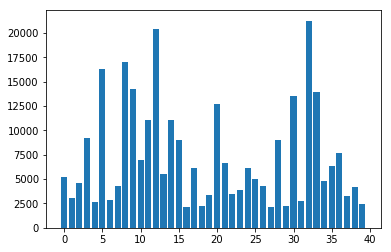

In [8]:
plt.bar(dategen.label_len.keys(), dategen.label_len.values())
plt.show()

Visualize training image, a quick check to see that input data is still sane:

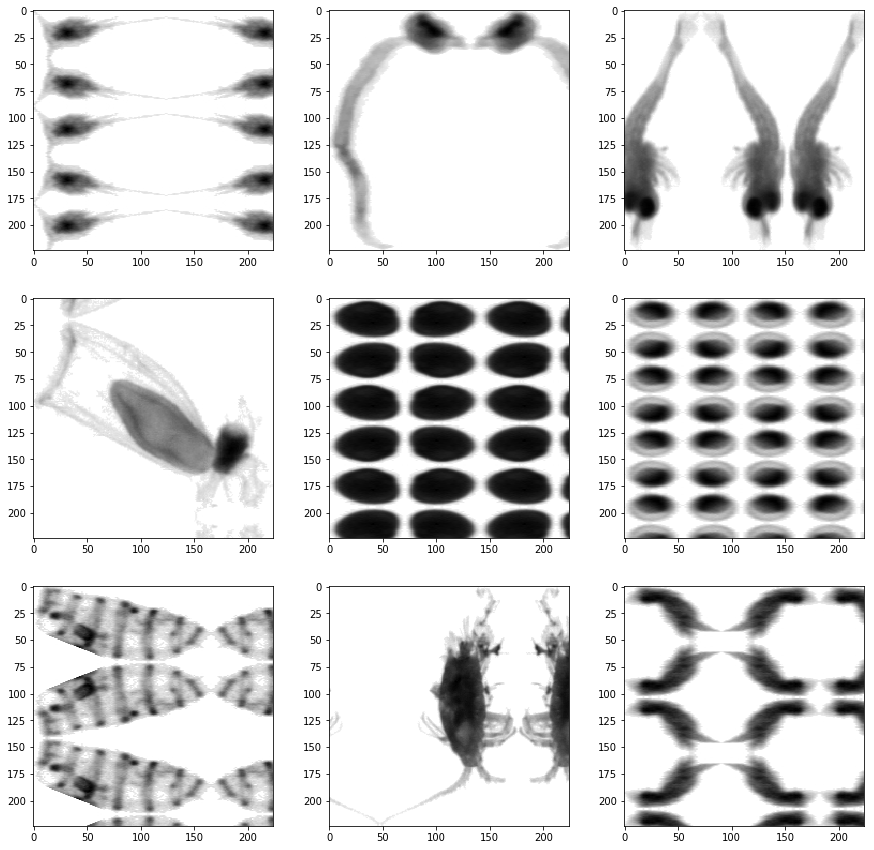

In [9]:
plt.figure(figsize=(15,15))
j = 1
for i in next(train_gen)[0][0]:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i[:,:,0], cmap="gray")
    j += 1
plt.show()   

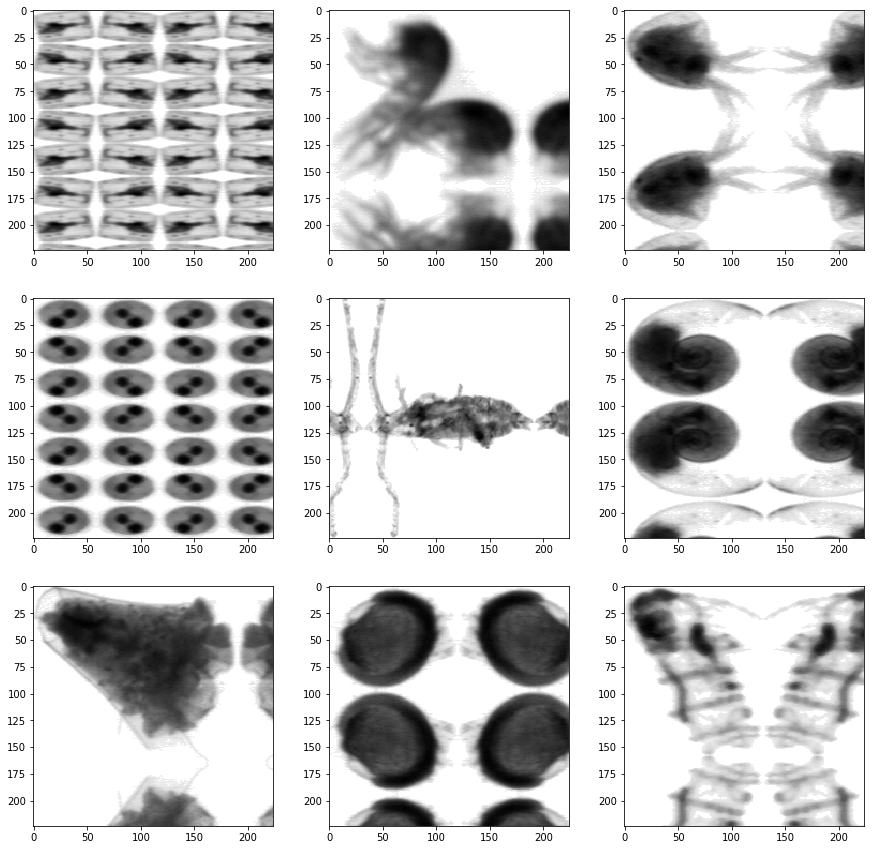

In [10]:
plt.figure(figsize=(15,15))
j = 1
for i in next(validation_gen)[0][0]:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i[:,:,0], cmap="gray")
    j += 1
plt.show()  

Now, lets make a small convolutional model:

In [22]:
# Copy paste from:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# Just to see if a simple model is better than pretrained network.

model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

#model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
#model.add(Dense(64, activation='relu') )

And customize it through the functional API. First I need to resize my input data to be consistent with the InceptionV3 model:

In [23]:
inputs_image = Input(shape=(224,224,1))
x = model(inputs_image)
#x = Dense(1024, activation='relu')(x)
outputs_image = Dense(1024, activation='relu')(x)
predictions_image = Dense(NUMBER_LABELS, activation='softmax', name="output")(outputs_image)

In [24]:
model_images = Model(inputs=inputs_image, outputs=predictions_image)
model_images.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/50
20/20 [==============================] - 52s 3s/step - loss: 5.5281 - acc: 0.1336 - val_loss: 4.9406 - val_acc: 0.1250

Epoch 00001: val_loss improved from inf to 4.94060, saving model to ../output/model_images/2019-02-20-21-23/model_fitted.h5
Epoch 2/50
20/20 [==============================] - 42s 2s/step - loss: 3.3307 - acc: 0.2426 - val_loss: 3.8069 - val_acc: 0.2141

Epoch 00002: val_loss improved from 4.94060 to 3.80694, saving model to ../output/model_images/2019-02-20-21-23/model_fitted.h5
Epoch 3/50
20/20 [==============================] - 43s 2s/step - loss: 2.6849 - acc: 0.2867 - val_loss: 3.2373 - val_acc: 0.2328

Epoch 00003: val_loss improved from 3.80694 to 3.23731, saving model to ../output/model_images/2019-02-20-21-23/model_fitted.h5
Epoch 4/50
20/20 [==============================] - 43s 2s/step - loss: 2.4081 - acc: 0.3332 - val_loss: 5.2773 - val_acc: 0.1891

Epoch 00004: val_loss did not improve from 3.23731
Epoch 5/50
20/20 [===========================

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


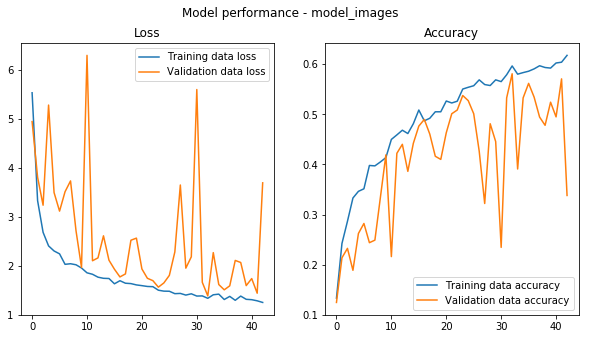

It has the following performance:
Validation loss: 3.6948283314704895
Validation accuracy: 0.3453125
Training time: 1522.8087549209595
It has the following confusion matrix:


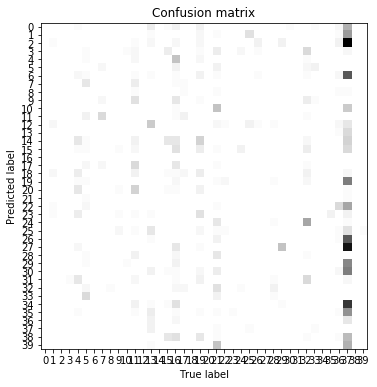

These are examples of misclassified features:


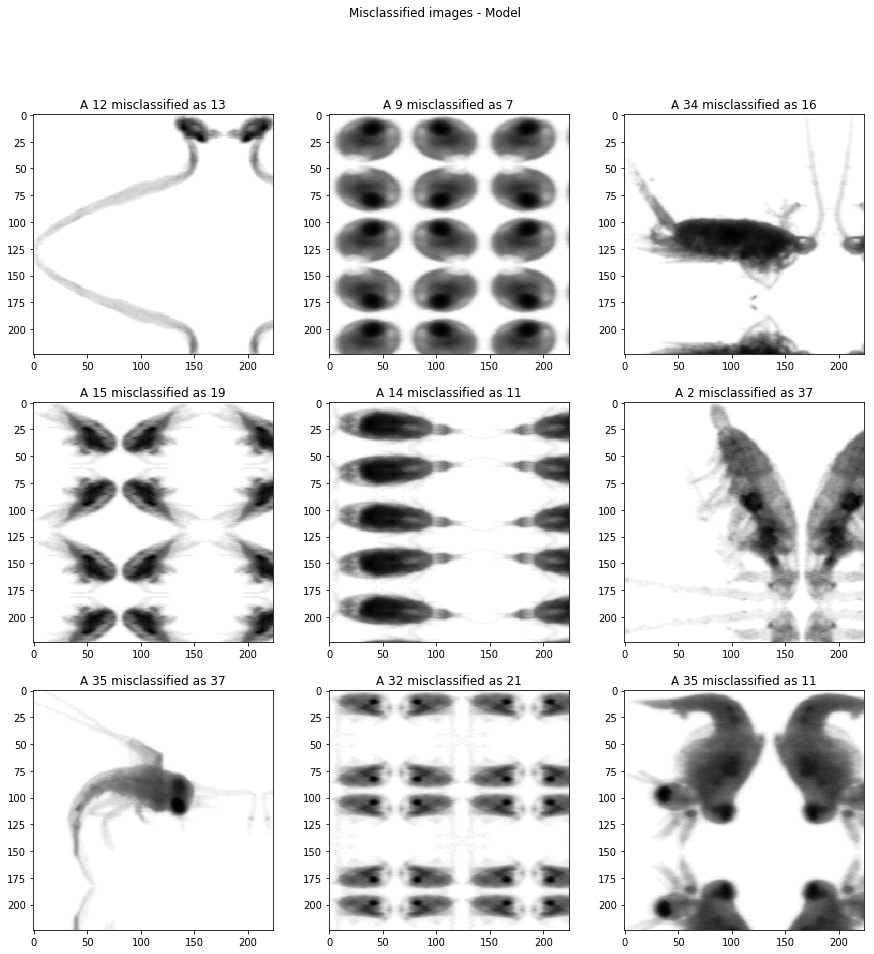

In [25]:
fit_and_save_model("model_images", model_images, make_image_generator(train_gen), make_image_generator(validation_gen),
                  steps_per_epoch = 20, validation_steps=20, epochs=50)

Now we define a second model that analyses the imagestatistics:

In [26]:
inputs_stat = Input(shape=(3,))
x = Dense(32, activation='relu')(inputs_stat)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_stat = Dense(64, activation='relu')(x)
predictions_stat = Dense(NUMBER_LABELS, activation='softmax', name="output")(output_stat)

In [27]:
model_stat = Model(inputs=inputs_stat, outputs=predictions_stat)
model_stat.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
                   steps_per_epoch = 20, validation_steps=20, epochs=50, img_input=False)

Epoch 1/50
20/20 [==============================] - 30s 1s/step - loss: 2.7385 - acc: 0.1746 - val_loss: 2.7470 - val_acc: 0.1758

Epoch 00001: val_loss improved from inf to 2.74699, saving model to ../output/model_stat/2019-02-20-22-00/model_fitted.h5
Epoch 2/50
 5/20 [======>.......................] - ETA: 6s - loss: 2.7158 - acc: 0.1766

KeyboardInterrupt: 

Now I make a composite model:

In [30]:
x = Concatenate()([outputs_image, output_stat])
x = Dropout(0.2)(x)
predictions = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

composite_model = Model(inputs=[inputs_image, inputs_stat], outputs=predictions)

composite_model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy", metrics=["accuracy"])

And fit the model to my training data:
TODO:
Make a multi-input mode that take both features_native and image data as input.
See: https://keras.io/getting-started/functional-api-guide/
Make custom datagenerator using: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
fit_and_save_model("composite_model", composite_model, train_gen, validation_gen,
                  steps_per_epoch = 20, validation_steps=20, epochs=50)

Epoch 1/50
20/20 [==============================] - 31s 2s/step - loss: 2.8891 - acc: 0.2457 - val_loss: 2.5506 - val_acc: 0.3125

Epoch 00001: val_loss improved from inf to 2.55060, saving model to ../output/composite_model/2019-02-20-22-01/model_fitted.h5
Epoch 2/50
20/20 [==============================] - 26s 1s/step - loss: 2.1322 - acc: 0.3812 - val_loss: 2.4639 - val_acc: 0.3344

Epoch 00002: val_loss improved from 2.55060 to 2.46393, saving model to ../output/composite_model/2019-02-20-22-01/model_fitted.h5
Epoch 3/50
20/20 [==============================] - 26s 1s/step - loss: 1.9981 - acc: 0.4234 - val_loss: 2.1201 - val_acc: 0.3977

Epoch 00003: val_loss improved from 2.46393 to 2.12009, saving model to ../output/composite_model/2019-02-20-22-01/model_fitted.h5
Epoch 4/50
19/20 [===========================>..] - ETA: 0s - loss: 1.8064 - acc: 0.4593

In [ ]:
#from keras.models import load_model
#model = load_model(r"C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\composite_model\2019-02-13-23-25\model_fitted.h5")
#fit_and_save_model("composite_model", model, train_gen, validation_gen,
#                  steps_per_epoch = 10, validation_steps=2, epochs=100 )

In [ ]:
# model.save('temp_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#from keras.models import load_model
#model = load_model('temp_model.h5')

The lower layer is: